# VarAnneal tutorial

VarAnneal is a Python package for state and parameter estimation in partially observed dynamical systems and neural networks.  It uses variational annealing (VA), a variational data assimilation method.

VA uses numerical optimization to estimate path-space statistics given by high-dimensional integrals of the form:
$$
\mathrm{E}\left[G(X) \lvert Y\right] = \frac{\int dX \: G(X)\: e^{-A(X,Y)}}{\int dX \: e^{-A(X,Y)}} \equiv \frac{1}{\mathcal{Z}(Y)} \int dX \: G(X)\: e^{-A(X,Y)}
$$
where $X$ is a vector of model states and parameters, and $Y$ is a vector of observational data.  Optimization is carried out using one of a variety of methods, such as L-BFGS-B, NCG, IPOPT (future), ...   These methods require derivatives of $A$, which are computed using automatic differentiation.

In dynamical systems, this amounts to estimating statistics for model parameters, as well as trajectories of model states, like the mode, mean, variance, ...  The data consists of time series of partial observations of the model variables.

In neural networks, this is used as a method of training the network weights on labeled data sets.

---

In [4]:
import numpy as np
from scipy import interpolate
from varanneal import va_ode
import os, time

In [5]:
%matplotlib nbagg
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mplcolors

from matplotlib import gridspec

# For 3D plots
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [6]:
from varanneal import va_ode

## Define the ODE system

Load in the input current

In [7]:
Ipath = "/Users/alexanderjulianty/neurodyn/IforRealNeuron.csv"
Idat = np.genfromtxt(Ipath, delimiter=',')

Set parameters

In [55]:
#Scaling Values
# The scale for V * C should match the scale for I
V_scale = 1 # V to V
C_scale = 1e9 # F to nF

# The scales for I * R should match the scale for V
I_scale = 1e9 # A to nA
R_scale = 1e-9 # O to nO

In [56]:
# Voltages
# Chip bias voltage
V_ref = 1 * V_scale
# Unit Volt(?)
V_unit = 26e-3 * V_scale

# Currents
# Master current(?)
I_master = 1.25e-9 * I_scale
# Voltage(?)
I_voltage = 230e-9 * I_scale
# Reference Current(?)
I_ref = 85e-9 * I_scale
# Injected current scale factor
I_inj_scale = (0.018) * 1e-9 * I_scale

# Capacitances
# Membrane Capacitance
C_m = 4e-12 * C_scale
# Gate capacitance
C_gate = 5e-12 * C_scale

# Resistances
Res = 1.63e6 * R_scale
R_bias = 1.85e6  * R_scale
R_factor = 700e3 * R_scale
R_factor2 = 50e3 * R_scale

# Scale Factors
kappa = 0.7

# Hodgkin Huxley Parameters
g0 = [800, 160, 15] #maximal conductances
e_rev = [300, -210, -190] #reversal potentials in mV

# Scaling H-H parameters for chip
g = np.multiply(g0,(kappa / V_unit) * (I_master / 1024))
E_rev = np.multiply(e_rev,(I_voltage / 1024) * Res) + V_ref


# Conductance Dynamics
vBias = np.zeros(7)
vHigh = V_ref + R_bias * I_voltage
vLow = V_ref - R_bias * I_voltage
I_factor = (vHigh - vLow) / R_factor
vBias[0] = vLow + I_factor * R_factor2

for i in xrange(1,7):
    #[635.2, 756.8, 878.42, 1000, 1121.57, 1243.14, 1364.7] in mV
    vBias[i] = vBias[i - 1] + I_factor * 2*R_factor2 
    
am = [0, 0, 120, 400, 800, 1023, 1023]
bm = [1023, 1023, 1023, 1023, 0, 0, 0]

ah = [237, 80, 0, 0, 0, 0, 0] #Jun's numbers
bh = [0, 0, 0, 0, 41, 50, 70] #Jun's numbers

an = [0, 0, 0, 0, 18, 5, 43] #Jun's numbers
bn = [1, 0, 0, 1, 0, 0, 1]

Define alpha and beta representations

In [57]:
def sigma(vBiask, V, sign = 1): #Why did we define sigma in this way?
    mu = 0.7
    Ut = 26e-3 * V_scale
    return 1 / (1 + np.exp(sign * mu * (vBiask - V) / Ut))

g_f = 1 / (C_gate * V_unit)

def alpha_spline(V, x, vBias=vBias, am=am, ah=ah, an=an):
    """
    Used to compute the conductance at each time point. 
    The optional arguments default to the parameters defined at the start of the document
    """
    alpha = 0
    for k in np.arange(7):
        if x == "m":
            alpha += am[k] * sigma(vBias[k], V, 1)
        if x == "h":
            alpha += ah[k] * sigma(vBias[k], V, -1)
        if x == "n":
            alpha += an[k] * sigma(vBias[k], V, 1)
    return alpha * I_master / 1024 * g_f


def beta_spline(V, x, vBias=vBias):
    beta = 0
    for k in np.arange(7):
        if x == "m":
            beta += bm[k] * sigma(vBias[k], V, -1)
        if x == "h":
            beta += bh[k] * sigma(vBias[k], V, 1)
        if x == "n":
            beta += bn[k] * sigma(vBias[k], V, -1)
    return beta * I_master / 1024 * g_f


Prepare injected current

In [58]:
#Used to interpolate time points that are undefined in Idat
fIdat = interpolate.interp1d(np.arange(0,len(Idat)), Idat) 

def I_inj(t, scale=I_inj_scale):
    if t[0] * 5e3 <= len(Idat):
        return fIdat(t * 5e3) * scale
    else:
        return 0

Define model

In [86]:
def neuron(t, y, k):
    #v, m, h, n = y
    v = y[:,0]
    m = y[:,1]
    h = y[:,2]
    n = y[:,3]
    # g = (2.62e-8, 5.25e-9, 4.9e-10)
    # E_rev = (1.109, 0.923, 0.9304)
    g = (k[0], k[1], k[2])
    E_rev = (k[3], k[4], k[5])
    
    I_na = g[0] * m**3 * h * (v - E_rev[0])
    I_k = g[1] * n**4 * (v - E_rev[1])
    I_l = g[2] * (v - E_rev[2])

    dvdt = (I_inj(t) - I_na - I_l - I_k) / C_m
    dmdt = alpha_spline(v, "m") * (1 - m) - beta_spline(v, "m") * m
    dhdt = alpha_spline(v, "h") * (1 - h) - beta_spline(v, "h") * h
    dndt = alpha_spline(v, "n") * (1 - n) - beta_spline(v, "n") * n
    dydt = np.transpose(np.array([dvdt, dmdt, dhdt, dndt]))
    
    return dydt

In [87]:
def nakl(t, y, P):
    """
    Neuron Model
    
    Paul's example has P as Pstim, which includes the stimulating current. Not sure if that is more efficient
    """
    v, m, h, n = (y[:,0], y[:,1], y[:,2], y[:,3])
    # Load parameters
    g = (P[0], P[1], P[2])
    E_rev = (P[3], P[4], P[5])
    vBias = (P[6:13])
    
    am = (P[13:20])
    bm = (P[20:27])
    ah = (P[27:34])
    bh = (P[34:41])
    an = (P[41:48])
    bn = (P[48:55])
    
    I_na = g[0] * m**3 * h * (v - E_rev[0])
    I_k = g[1] * n**4 * (v - E_rev[1])
    I_l = g[2] * (v - E_rev[2])

    dydt = np.zeros_like(y)

    dydt[:,0] = (I_inj(t) - I_na - I_l - I_k) / C_m
    dydt[:,1] = alpha_spline(v, "m", vBias) * (1 - m) - beta_spline(v, "m", vBias) * m
    dydt[:,2] = alpha_spline(v, "h", vBias) * (1 - h) - beta_spline(v, "h", vBias) * h
    dydt[:,3] = alpha_spline(v, "n", vBias) * (1 - n) - beta_spline(v, "n", vBias) * n
    
    return dydt

#### Action/annealing (hyper)parameters

In [101]:
# Model system dimension
D = 4

# Measured variable indices
# (-, t) (0, v) (1, m) (2, h) (3, n) (4, I)
Lidx = [0, 1, 2, 3]

# RM, RF0
RM = 1.0 / (0.5**2)
RF0 = 4.0e-6

# alpha, and beta ladder
alpha = 1.5
beta_array = np.linspace(0, 100, 100)
#beta_array = np.linspace(0, 10, 11)

g0 = RF0/RM
gammas_all = g0 * alpha**beta_array

#### Load observed data

In [102]:
data = np.load("/Users/alexanderjulianty/neurodyn/ode_data.npy")
times_data = data[:, 0]
dt_data = times_data[1] - times_data[0]
N_data = len(times_data)

#extracting observed data here
data = data[:, 1:]
data = data[:, Lidx]

Set $\Delta t_f$ based on $\Delta t$.

In [103]:
# model state discretization
freq_mod = 1.0  # how often to put down a state variable
dt_model = dt_data / freq_mod
if freq_mod == 1.0:
    N_model = N_data
else:
    N_model = int(N_data * freq_mod) - 1

#### Initial path/parameter guesses
Later in the notebook, we'll have the option of setting the initial guesses for the observed variables equal to the observations themselves.

In [104]:
# State variables
# This should be an array with N_f elements, where element n_f is a D-dimensional 
# vector. In other words, this is an array of state vectors at all "model times".
X0 = (20.0*np.random.rand(N_model * D) - 10.0).reshape((N_model, D))

n_params = 6
# Parameters
Pidx = np.arange(0,n_params)

In [105]:
# Initial guesses
Pg = []
Pg.append([2.0e1, 3.0e1]) # g[0]
Pg.append([5.0, 6.0]) # g[1]
Pg.append([4.5e-1, 5.5e-1]) # g[2]
Pg.append([1.000, 1.200]) # E_rev[0]
Pg.append([0.800, 1.000]) # E_rev[1]
Pg.append([0.800, 1.000]) # E_rev[2]


Pinit = np.zeros(len(Pidx))
for i, b in enumerate(Pg):
    r = b[1] - b[0]
    Pinit[i] = r*np.random.rand() + b[0]
Pinit = np.array(Pinit)

#### Use VA to estimate states and parameters
First we need to initialize an Annealer object, which stores information about the model, data, annealing hyperparameters, and the action.  It also executes the VA algorithm, then is used to save the state and parameter estimates to file.

In [106]:
# Initialize Annealer
anneal1 = va_ode.Annealer()

# Set the model
anneal1.set_model(neuron, D)

# Load the data into the Annealer object
anneal1.set_data(data, t=times_data)

Run VA

In [107]:
# First set some options for the optimization.
# Bounds
bounds = [[-0.5, 1.5], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0]]
for i in xrange(len(Pidx)):
    bounds.append(Pg[i])
    
    
# The full list of options can be found in the scipy.optimization package documentation.
BFGS_options = {'gtol':1.0e-8, 'ftol':1.0e-8, 'maxfun':1000000, 'maxiter':1000000}

tstart = time.time()  # time how long VA takes

# Annealer.anneal() executes VA for all beta values (defined above)
# Note the init_to_data option: this initializes the measured variables to the data.
anneal1.anneal(X0, Pinit, alpha, beta_array, RM, RF0, Lidx, Pidx, dt_model=dt_model,
               init_to_data=True, disc='SimpsonHermite', method='L-BFGS-B',
               opt_args=BFGS_options, adolcID=0)

print("\nADOL-C annealing completed in %f s."%(time.time() - tstart))

------------------------------
Step 1 of 100
beta = 0, RF = 4.00000000e-06

Taping action evaluation...
Done!
Time = 4.39014101028 s

Beginning optimization...
Optimization complete!
Time = 0.662083864212 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 1
Obj. function value = [  7.45017288e-10]

------------------------------
Step 2 of 100
beta = 1, RF = 6.00000000e-06

Taping action evaluation...
Done!
Time = 5.0576570034 s

Beginning optimization...
Optimization complete!
Time = 0.680463075638 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 1
Obj. function value = [  1.11190391e-09]

------------------------------
Step 3 of 100
beta = 2, RF = 9.00000000e-06

Taping action evaluation...
Done!
Time = 6.44378900528 s

Beginning optimization...
Optimization complete!
Time = 0.717123985291 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 1
Obj. function value = [

Done!
Time = 5.34941887856 s

Beginning optimization...
Optimization complete!
Time = 0.840698003769 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 1
Obj. function value = [  5.64663684e-07]

------------------------------
Step 26 of 100
beta = 25, RF = 1.01004673e-01

Taping action evaluation...
Done!
Time = 5.21389985085 s

Beginning optimization...
Optimization complete!
Time = 1.70836496353 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 4
Obj. function value = [  6.40566980e-07]

------------------------------
Step 27 of 100
beta = 26, RF = 1.51507010e-01

Taping action evaluation...
Done!
Time = 5.08376097679 s

Beginning optimization...
Optimization complete!
Time = 0.697362184525 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 1
Obj. function value = [  7.48809959e-07]

------------------------------
Step 28 of 100
beta = 27, RF = 2.27260515e-01

Tap

Done!
Time = 6.78210306168 s

Beginning optimization...
Optimization complete!
Time = 58.1992530823 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 188
Obj. function value = [  2.80320541e-05]

------------------------------
Step 50 of 100
beta = 49, RF = 1.70032400e+03

Taping action evaluation...
Done!
Time = 7.48394203186 s

Beginning optimization...
Optimization complete!
Time = 1.06713700294 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 1
Obj. function value = [  3.61578346e-05]

------------------------------
Step 51 of 100
beta = 50, RF = 2.55048600e+03

Taping action evaluation...
Done!
Time = 7.12379813194 s

Beginning optimization...
Optimization complete!
Time = 0.980166912079 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 1
Obj. function value = [  4.83464984e-05]

------------------------------
Step 52 of 100
beta = 51, RF = 3.82572900e+03

Ta

Done!
Time = 4.1015598774 s

Beginning optimization...
Optimization complete!
Time = 13.4720740318 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 61
Obj. function value = [ 0.00371759]

------------------------------
Step 75 of 100
beta = 74, RF = 4.29351675e+07

Taping action evaluation...
Done!
Time = 4.02004289627 s

Beginning optimization...
Optimization complete!
Time = 0.64312005043 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 1
Obj. function value = [ 0.00552117]

------------------------------
Step 76 of 100
beta = 75, RF = 6.44027512e+07

Taping action evaluation...
Done!
Time = 4.04238700867 s

Beginning optimization...
Optimization complete!
Time = 0.749815940857 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 1
Obj. function value = [ 0.00822654]

------------------------------
Step 77 of 100
beta = 76, RF = 9.66041269e+07

Taping action evalu

KeyboardInterrupt: 

# Save action, constituent errors, and state/parameter estimates to file.

In [108]:
anneal1.save_paths("neurodyn/paths.npy") #state paths
anneal1.save_params("neurodyn/params.npy")
anneal1.save_action_errors("neurodyn/action_errors.npy")#saves action and constituent errors

### Plot the results

#### One measured, one unmeasured state variable

In [109]:
# Load path estimates and action curves
allpaths = np.load("neurodyn/paths.npy")
aerr = np.load("neurodyn/action_errors.npy")
params = np.load("neurodyn/params.npy")
# Load the true solution
true_soln = np.load("/Users/alexanderjulianty/neurodyn/ode_data.npy")

In [112]:
params[80,0:6]

array([ 27.16439883,   5.09436834,   0.49531411,   1.10741752,
         0.92259749,   0.93002579])

<IPython.core.display.Javascript object>


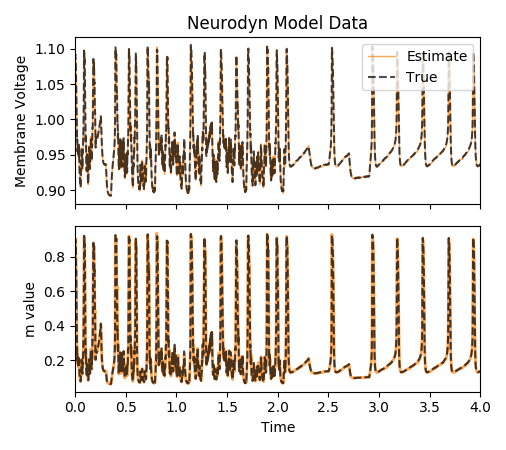

In [113]:
good_beta = [0, 5, 10, 40, 50, 100]
beta_show = 80

plot_idx_meas = 1
plot_idx_unmeas = 2

# plot all path estimates at this beta simultaneously
fig,ax = plt.subplots(2, 1, figsize=(3.375*1.5, 3*1.5), sharex=True)
fig.set_tight_layout(True)

tplot = allpaths[beta_show, :, 0]

# plot the estimate
ax[0].plot(tplot, allpaths[beta_show, :, plot_idx_meas], color="C1", alpha=0.7, lw=1.0, label="Estimate")
# plot the true solution
ax[0].plot(tplot, true_soln[:, plot_idx_meas], color="black", lw=1.5, ls="--", label="True", alpha=0.7)
ax[0].set_xlim(tplot[0], tplot[-1])
ax[0].set_ylabel(r"Membrane Voltage")
ax[0].set_title(r"Neurodyn Model Data")

h,l = ax[0].get_legend_handles_labels()
ax[0].legend(h,l)

# plot the estimate
ax[1].plot(tplot, allpaths[beta_show, :, plot_idx_unmeas], color="C1", alpha=0.7, lw=2.0)
# plot the true solution
ax[1].plot(tplot, true_soln[:, plot_idx_unmeas], color="black", lw=1.5, ls="--", alpha=0.7)
ax[1].set_xlim(tplot[0], tplot[-1])
ax[1].set_ylabel(r"m value")
ax[1].set_xlabel("Time")

plt.show()


#### Plot the action

<IPython.core.display.Javascript object>


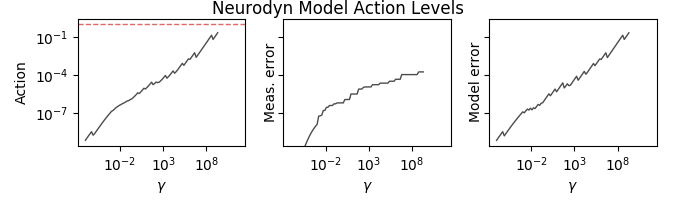

In [114]:
#save_plot_data = False
#save_plot_data_dir = "plot_files/plot_data_action_allterms_L8_onedataset/"

fig,ax = plt.subplots(1, 3, figsize=(6.75, 2.1), sharey=True)
fig.set_tight_layout(True)

ymin = 1.0e20
ymax = 0.0

plotlw = 1.0
plotalpha = .7
#plotcolors = ["C0", "C0", "C0"]
plotcolors = ["black", "black", "black"]

action_vals = aerr[:, 1]
ax[0].plot(gammas_all[:], action_vals, lw=plotlw, color=plotcolors[0], alpha=plotalpha)
ax[0].set_xlabel(r"$\gamma$")
ax[0].set_ylabel("Action")
ax[0].axhline(y=1, lw=1, ls="--", color="C3", alpha=.7)

measerr_vals = aerr[:, 2]
ax[1].plot(gammas_all[:], measerr_vals, lw=plotlw, color=plotcolors[1], alpha=plotalpha)
ax[1].set_xlabel(r"$\gamma$")
ax[1].set_ylabel("Meas. error")

moderr_vals = aerr[:, 3]
ax[2].plot(gammas_all[:], moderr_vals, lw=plotlw, color=plotcolors[2], alpha=plotalpha)
ax[2].set_xlabel(r"$\gamma$")
ax[2].set_ylabel("Model error")

fig.suptitle("Neurodyn Model Action Levels", y=1.0)

for i in range(3):
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
#    ax[i].set_xlim(1.0e-2, 1.0e7)
#    ax[i].set_ylim(.001, 1.0e2)

plt.show()

---